In [1]:
%matplotlib inline
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import kruskal, f_oneway
from scipy.stats import ttest_ind

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy
import library.fit as ft

In [2]:
mm_genes = '../data/hydra-target-tree-0/MultiModalGenes/'
exp_path = '../data/TARGET-OSTEO-TREE-Cluster-0.tsv'

In [3]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

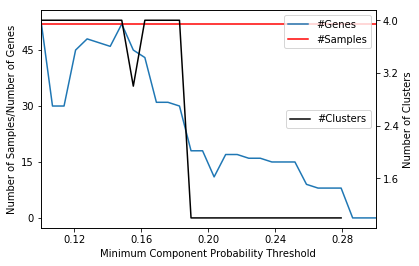

In [4]:
if True:

    scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                     exp_path, 
                                     'GO',
                                     min_prob_range=np.linspace(0.1, 0.3, 30), 
                                     CPU=7,
                                     K=5).scan()
    
    scan

In [5]:
scan

,num_genesets,gs_terms,gs_term_genes,num_genes,num_clusters,num_samples
min_prob_filter,,,,,,
0.100000,4,muscle contraction|response to drug|homophilic...,PTGS2|ACTA1|MYH14|HAND2|SLC6A2|ACTC1|FOSB|DES|...,53,4,52
0.106897,2,muscle contraction|homophilic cell adhesion vi...,PTGS2|MYH14|ACTC1|DES|NEB|PCDHGB7|PCDHGB5|TRDN...,30,4,52
0.113793,2,muscle contraction|homophilic cell adhesion vi...,PTGS2|MYH14|ACTC1|DES|NEB|PCDHGB7|PCDHGB5|TRDN...,30,4,52
0.120690,4,multicellular organismal signaling|homophilic ...,SLC6A2|DMRT3|MYH14|HAND2|ACTC1|FOSB|JUND|PCDHG...,45,4,52
0.127586,5,muscle contraction|homophilic cell adhesion vi...,SLC6A2|MYH14|HAND2|ACTC1|FOSB|DES|NEB|JUND|PCD...,48,4,52
0.134483,4,muscle contraction|homophilic cell adhesion vi...,SLC6A2|MYH14|HAND2|ACTC1|DES|NEB|JUND|PCDHGB7|...,47,4,52
0.141379,4,muscle contraction|homophilic cell adhesion vi...,SLC6A2|MYH14|HAND2|ACTC1|DES|NEB|JUND|PCDHGB7|...,46,4,52
0.148276,6,multicellular organismal signaling|muscle cont...,SLC6A2|DMRT3|MYH14|CCK|ACTC1|PCDHGB5|DES|NEB|P...,52,4,52
0.155172,4,regulation of system process|multicellular org...,SLC6A2|DMRT3|MYH14|HAND2|PCDHGA10|PCDHGB5|DES|...,45,3,52


In [6]:
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.182759,
                            gmt_path='GO')

In [7]:
genes = res.get_enriched_term_genes()

len(genes)

30

In [8]:
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

centering data


In [9]:
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

In [10]:
# Non-Muscle
pth = '../data/TARGET-OSTEO-TREE-Cluster-0-NO-MUSCLE.tsv'
exp.reindex(assign[assign[1] != 3].index.values, axis=1).to_csv(pth, sep='\t')

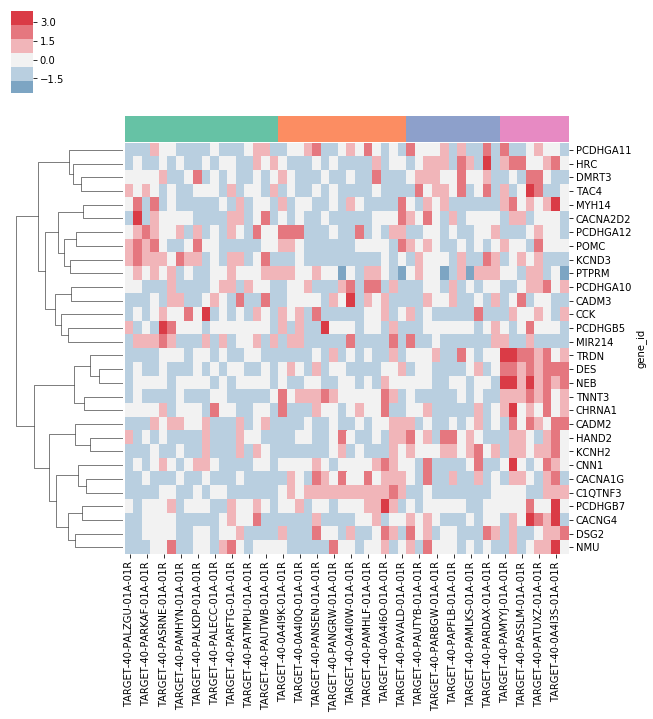

In [11]:
col_order = assign.sort_values(1).index.values
cmap = sns.color_palette("Set2", max(assign[1].values))
col_colors = [cmap[x - 1] for x in assign.sort_values(1)[1].values]

g = sns.clustermap(exp.reindex(genes).reindex(col_order, axis=1),
                   col_cluster=False,
                   col_colors=col_colors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

#ax.set_xticklabels([])
#ax.set_xticks([])
#ax.set_yticklabels([])
#ax.set_yticks([])

pth = '../img/target-th-cluster-0-expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/target-th-cluster-0-expression-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [12]:
fgsea = clus.get_cluster_features(exp, 
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [14]:
def format_pathway(x):
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

In [17]:
for key, values in fgsea.items():
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10))

Key:  0                                              pathway      padj       NES
0     HALLMARK_INTERFERON_ALPHA_RESPONSE (MSIGDB_C2)  0.013504  3.645049
1     HALLMARK_INTERFERON_GAMMA_RESPONSE (MSIGDB_C2)  0.013504  3.408065
2     HALLMARK_OXIDATIVE_PHOSPHORYLATION (MSIGDB_C2)  0.013504  3.128775
3         INTERFERON ALPHA BETA SIGNALING (REACTOME)  0.013504  3.026390
4  IMMUNOREGULATORY INTERACTIONS BETWEEN A LYMPHO...  0.013504  3.015409
5         TYPE I INTERFERON SIGNALING PATHWAY (GOBP)  0.013504  2.980356
6      CELLULAR RESPONSE TO TYPE I INTERFERON (GOBP)  0.013504  2.980356
7      EUKARYOTIC TRANSLATION TERMINATION (REACTOME)  0.013504  2.969436
8      TYROBP CAUSAL NETWORK (WIKIPATHWAYS_20181110)  0.013504  2.943915
9  SRP-DEPENDENT COTRANSLATIONAL PROTEIN TARGETIN...  0.013504  2.939609
Key:  1                                              pathway      padj       NES
0  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION (MS...  0.022229  4.458519
1                    NABA_CORE_MATR

In [ ]:
pth = '../img/TARGET-THC0-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

In [ ]:
def get_event(event):
    if pd.isnull(event):
        print("NULL")
        return np.nan
    
    events = ['Relapse',
              'Death', 
              'Progression',
              'Event',
              'Second Malignant Neoplasm',
              'SMN']
    
    if event in ['Censored', 'No event', 'None']:
        return 0
    
    elif event in events:
        return 1 
    
    else:
        raise ValueError(event)
        
def get_vital(vital):
    if pd.isnull(vital):
        #print("NULL")
        return np.nan
    
    
    if vital == 'Alive':
        return 0
    
    elif vital == 'Dead':
        return 1
    
    else:
        raise ValueError(vital)

pth = '../../without-muscle/data/TARGET_OS_ClinicalData_Discovery_20181009.xlsx'
clinical = pd.read_excel(pth, index_col=0)

surv = pd.DataFrame(index=[x for x in exp.columns if x.startswith('TARGET')], 
                    columns=['OS', 'vital', 'EFS', 'event'])

for sample in exp.columns:
    root = '-'.join(sample.split('-')[:3])
    if root not in clinical.index:
        print "Missing: ", sample
        continue
    
    OS = clinical.loc[root, 'Overall Survival Time in Days'].item()
    vital = get_vital(clinical.loc[root, 'Vital Status'])
    
    EFS = clinical.loc[root, 'Event Free Survival Time in Days'].item()
    event = get_event(clinical.loc[root, 'First Event'])
    
    surv.loc[sample, :] = [OS, vital, EFS, event]
    

for sample in surv.index.values:
    surv.loc[sample, 'cluster'] = int(assign.loc[sample, 1])
    
surv = surv.dropna()
    
surv.to_csv('../data/TARGET-osteo-THC0-survival.tsv', sep='\t')

surv